# 1. Setup Mario

In [15]:
import gym
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np
import time

from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

import torch
torch.cuda.is_available()


CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

# 2. Preprocess Environment

In [10]:
class SkipFrame(gym.Wrapper):
    '''
        Custom wrapper that inherits from gym.Wrapper and implements the step() function.
        Use it to return only every nth frame with the total accumulated reward
    '''
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip + 1
        
    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [24]:
env = gym.make('SuperMarioBrosRandomStages-v1', stages=['1-1'])
env = Monitor(env, LOG_DIR)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = SkipFrame(env, skip=1)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [25]:
state = env.reset()

In [22]:
state, reward, done, info = env.step([3])

states = []
for _ in range(4):
    state, reward, done, info = env.step([4])
    states.append(state)

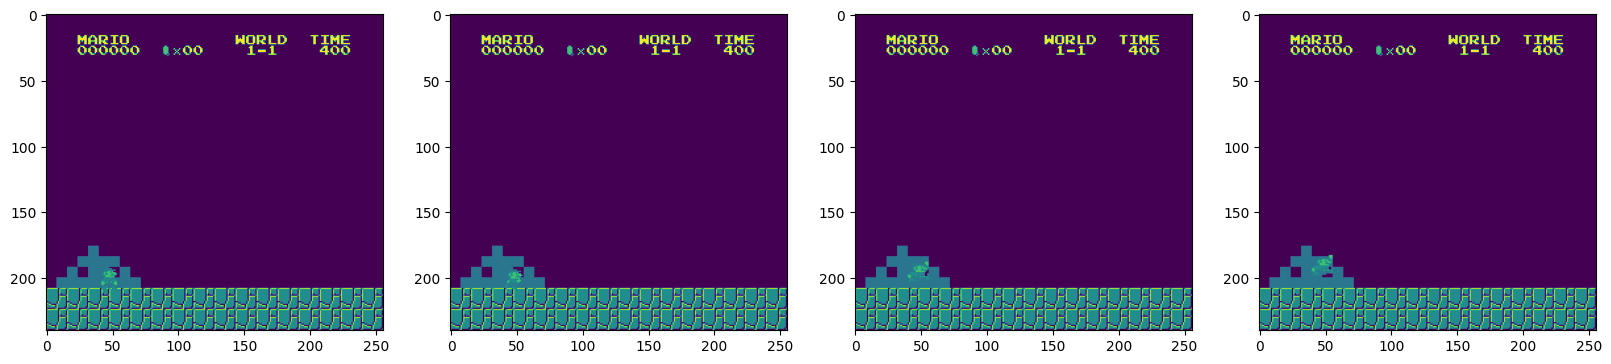

In [153]:
plt.figure(figsize=(20,16))
for idx, state in enumerate(states):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:, :, 3])
plt.show()

# 3. Train the RL Model

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

        self.best_mean_reward = -np.inf

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)  

    def _on_step(self):
        
        if self.n_calls % self.check_freq == 0:

            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            
            if len(x) > 0:

                mean_reward = np.mean(y[-50:])

                if mean_reward > self.best_mean_reward:

                    self.best_mean_reward = mean_reward
                    model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
                    self.model.save(model_path)           

        return True

callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [134]:
continue_train = False

if continue_train:
    model = PPO.load('./train/SuperMarioBros-1-1-v1-model-10M') # , learning_rate= 0.000001)
    model.set_env(env)
else:
    model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate= 0.000001, # 0.000001, 
            n_steps=512, device="cuda")

Using cuda device
Wrapping the env in a VecTransposeImage.


In [136]:
model.learn(total_timesteps=5000000, callback=callback)

Logging to ./logs/PPO_22
----------------------------
| time/              |     |
|    fps             | 165 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------


KeyboardInterrupt: 

In [161]:
model.save('./train/SuperMarioBros-1-1-v1-model-3M-fs1')

# 4. Save actions best run

In [35]:
model = PPO.load('./train/SuperMarioBros-1-1-v1-model-10M') # 1.000.000 + 230.000 + 4.000.000 + 600.000 + 2.000.000 + 2.170.000

In [153]:
model = PPO.load('./train/SuperMarioBros-1-1-v3-model-1M')

In [154]:
env = gym.make('SuperMarioBrosRandomStages-v3', stages=['1-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = SkipFrame(env, skip=1)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [155]:
# model.set_random_seed(seed=42)

# env.seed(42)
# env.action_space.seed(42)

# torch.manual_seed(42)
# torch.random.manual_seed(42)

# np.random.seed(42)

In [199]:
def run_experiments(env, n_simulations, model):

    state = env.reset()
    rewards = []
    total_reward = 0

    best_run = (-16, [])
    action_list = []

    while True:

        action, _ = model.predict(state)
        action_list.append(action)
        state, reward, done, info = env.step(action)

        if done:

            if total_reward > best_run[0]: 
                best_run = (total_reward, action_list.copy())

            action_list = []

            rewards.append(total_reward)
            total_reward = 0
            state = env.reset()
        else:
            total_reward += reward

        if len(rewards) >= n_simulations:
            break

    return np.array(rewards), best_run

# 5. Simulate best run

In [249]:
env = gym.make('SuperMarioBrosRandomStages-v1', stages=['1-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# # env = SkipFrame(env, skip=1)
# env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
# env = VecFrameStack(env, 4, channels_order='last')

In [250]:
for _ in range(1):
    state = env.reset()

    for action in best_run[1]:

        state, reward, done, info = env.step(action)

        if done:
            state = env.reset()
        time.sleep(0.01)
        env.render()
env.close()

# 6. Test in unknown level (2-1) experiment

In [36]:
env = gym.make('SuperMarioBrosRandomStages-v1', stages=['2-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = SkipFrame(env, skip=1)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [124]:
for _ in range(4):

    state = env.reset()

    while True:

        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)

        if done:
            break

        # time.sleep(0.001)
        # time.sleep(0.05)
        
        env.render()
env.close()

# Environments experiment

Min: 242.0  Mean: 945.166  Max: 3035.0
Min: 239.0  Mean: 772.604  Max: 3013.0
Min: 249.0  Mean: 861.914  Max: 3052.0


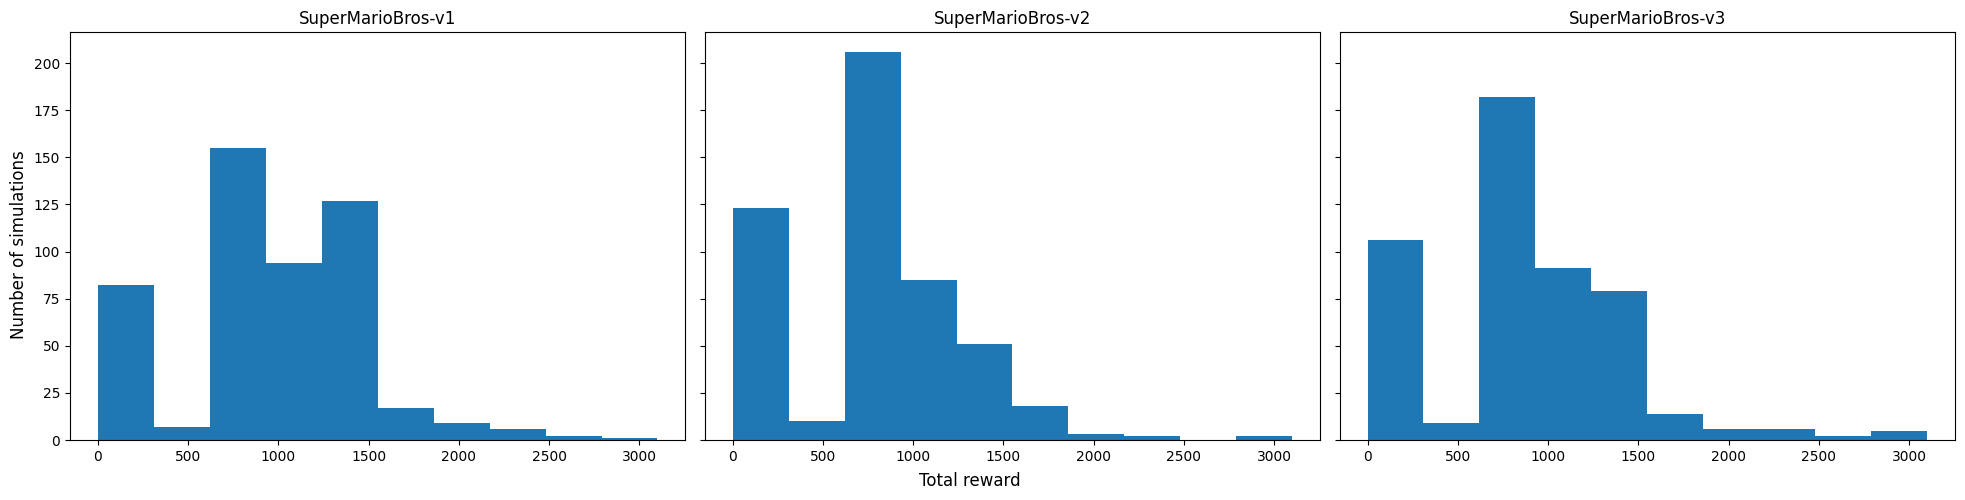

In [201]:
n_simulations = 500
fig = plt.figure(figsize=(20,5))
axes = fig.subplots(nrows=1, ncols=3, sharey='row')

all_rewards = []

for version, col in enumerate(axes):
    
    model = PPO.load('./train/SuperMarioBros-1-1-v'+str(version+1)+'-model-1M')

    env = gym.make('SuperMarioBrosRandomStages-v'+str(version+1), stages=['1-1'])
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = GrayScaleObservation(env, keep_dim=True)
    env = DummyVecEnv([lambda: env])
    env = VecFrameStack(env, 4, channels_order='last')

    rewards, best_run = run_experiments(env, n_simulations, model)
    all_rewards.append(rewards)

    print('Min:',rewards.min(),' Mean:',rewards.mean(),' Max:',rewards.max())
    col.hist(rewards, range=[0, 3100])
    col.title.set_text('SuperMarioBros-v'+str(version+1))

plt.tight_layout()
fig.supxlabel('Total reward')
fig.supylabel('Number of simulations')
plt.subplots_adjust(left=0.05, bottom=0.11)
plt.show()

In [211]:
# save rewards
for version, rewards in enumerate(all_rewards):
    np.save("environment_v"+str(version+1)+"_rewards.npy", rewards)

Min: 242.0  Mean: 945.166  Max: 3035.0
Min: 239.0  Mean: 772.604  Max: 3013.0
Min: 249.0  Mean: 861.914  Max: 3052.0


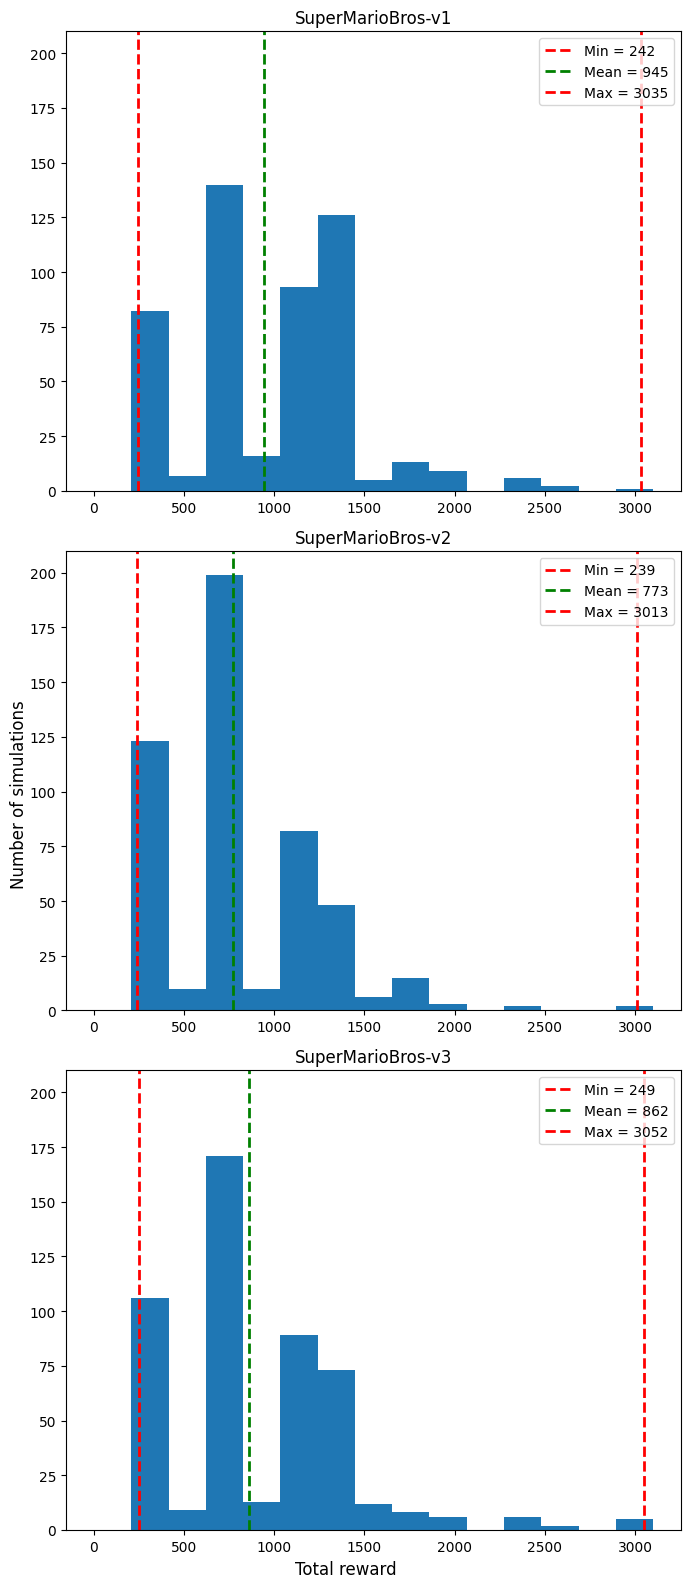

In [291]:
fig = plt.figure(figsize=(7,16))
axes = fig.subplots(nrows=3, ncols=1, sharey='row')

for version, col in enumerate(axes):

    rewards = all_rewards[version]

    col.vlines(rewards.min(), 0, 1200, label='Min = '+str(round(rewards.min())), colors='r', lw=2, linestyles='dashed')
    col.vlines(rewards.mean(), 0, 1200, label='Mean = '+str(round(rewards.mean())), colors='g', lw=2, linestyles='dashed')
    col.vlines(rewards.max(), 0, 1200, label='Max = '+str(round(rewards.max())), colors='r', lw=2, linestyles='dashed')
    print('Min:',rewards.min(),' Mean:',rewards.mean(),' Max:',rewards.max())
    col.hist(rewards, 15, range=[0, 3100])
    col.title.set_text('SuperMarioBros-v'+str(version+1))
    col.set_ylim(0,210)
    col.legend()

plt.tight_layout()
fig.supxlabel('Total reward')
fig.supylabel('Number of simulations')
plt.subplots_adjust(left=0.1, bottom=0.04)
plt.show()

In [234]:
np.save("tering_goeie_run_v3_1M_steps.npy", best_run[1])

In [6]:
plot_results(['logs/PPO-10M/'], 1e6, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in logs/PPO-10M/